# Modeling Brain Dynamics in Stroke Patients Using the Virtual Brain  
In this demo, we show how to simulate large-scale brain dynamics using The Virtual Brain, an open-source neuroinformatics platform. 

In [1]:
# load libraries
import csv
import matplotlib.pyplot as plt
import multiprocessing as mp 
import numpy as np
import os
import pandas as pd
import scipy
import scipy.io as sio
import scipy.signal as sig
import scipy.stats as stat
import sys
import zipfile
#from tvb.simulator.plot.tools import *
from tvb.simulator.lab import *
from tvb.simulator.models import *
from tvb.datatypes.time_series import TimeSeriesRegion
from tvb.analyzers import fmri_balloon
import tvb.analyzers.correlation_coefficient as corr_coeff
LOG = get_logger('Stroke')

   INFO  log level set to INFO


/home/danielelab/Programs/TVB_Distribution/tvb_data/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


## Introduction  
We show how to simulate neural mass model with the reduced Wong-Wang model, using the individual subject connectivity. The global model parameters of the reduced Hindmarsh–Rose model are individually optimized to improve prediction accuracy of functional connectivity.
<br>
Original publication can be found here: https://www.ncbi.nlm.nih.gov/pubmed/27088127  
<br>
When using The Virtual Brain for scientific publications, please cite it as follows:  
<pre><code>Paula Sanz Leon, Stuart A. Knock, M. Marmaduke Woodman, Lia Domide,
Jochen Mersmann, Anthony R. McIntosh, Viktor Jirsa (2013)
    The Virtual Brain: a simulator of primate brain network dynamics.
Frontiers in Neuroinformatics (7:10. doi: 10.3389/fninf.2013.00010)</code></pre>
![](images/workflow.jpg?raw=true)

## Load Individual Connectivity
Data contains functional and structural connectivity matrices of stroke tumor patients
<br>
Put Input data folder in the same directory of this python notebook.
Input data needs to follow the directory structure below:
```
TVB_stroke.ipynb
TVB_input
│   derivatives
│       sub-CON01
│           ses-preop
│           │   FC.mat
│           │   SCthrAn.mat
│           └───SC.zip
│                  │   areas.txt
│                  │   average_orientations.txt
│                  │   centres.txt
│                  │   cortical.txt
│                  │   hemisphere.txt
│                  │   tract_lengths.txt.txt
│                  │   weights.txt
│   
└───────sub-CONXX
        │   ...
```

In [3]:
# Set directory path
data_dir = os.getcwd() + "/TVB_input/derivatives/TVB/sub-CON29/ses-preop"

In [4]:
def load_connectivity(input_name):
    zip_file_name = input_name + ".zip"
    zip_path = data_dir + "/" + zip_file_name
    #dir_path = data_dir + "/" + input_name + "/" + dir_name
    # Load the connectivity data
    conn = connectivity.Connectivity.from_file(zip_path)
    # Configure, to compute derived data, such as number_of_nodes and delays
    conn.configure()
    
    # Check weight matrix from .zip is corresponding to structural connectivity matrix from matlab file. 
    #with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    #    zip_ref.extractall(dir_path)
    #weight_txt = np.loadtxt(fname = dir_path + "/weights.txt")
    # Load the structural connectivity matrix from matlab file
    #SC_path = data_dir + "/" + input_name + "/SCthrAn.mat"
    #x = sio.loadmat(SC_path)
    #assert(np.allclose(x['SCthrAn'], weight_txt), "Weight matrix in weights.txt should be the same as SCthrAn.mat")
    return conn



WARNING  File 'hemispheres' not found in ZIP.


Text(0.5,1.05,u'Structural connectivity for subject SC')

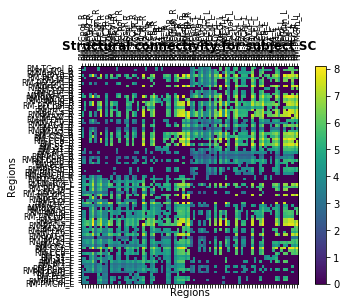

In [14]:
# Load the structural connectivity data
input_name = "SC"

conn = load_connectivity(input_name)


# Show connectivity summary information.
conn.summary_info

# Plot Structural Connectivity Info: A 2D plot for visualizing the Connectivity.weights matrix
plot_connectivity(connectivity = conn, plot_tracts=False)
plt.xlabel("Regions")
plt.ylabel("Regions")
connectivity_title = "Structural connectivity for subject " + input_name
plt.title(connectivity_title, fontweight="bold", fontsize="12", y = 1.05)

## Load Empirical Functional Connectivity matrix

In [15]:
# get empirical functional connectivity from FC.mat
# in this demo the functional connectivity parameter name is FC_cc_DK68, adjust to your variable name
fc_file_name = data_dir + "/FC.mat"
fc_cc_name = "currentFC"
em_fc_matrix = sio.loadmat(fc_file_name)[fc_cc_name]

# indexes of all the values above the diagonal.
uidx = np.triu_indices(em_fc_matrix.shape[0], 1)

# Fisher-Z transform the correlations, important for standardization
em_fc_z = arctanh(em_fc_matrix)
# get the upper triangle since it is symmetric along diagonal
em_fc = em_fc_z[uidx]

## Configure Simulator
Reduced Wong-Wang model with an excitatory and an inhibitory population, mutually coupled.
<br>
Table below shows parameters defined in Reduced Wong-Wang model, default value and description.

| Parameter Name | Default Value   | Description |
|--------------|-------------|-----------|
| a            | 1           |   Constants affecting faster ion channels                                          |
| b            | 3           |   Constants affecting faster ion channels                                       |
| c            | 1           |   Constants affecting faster ion channels                                        |
| d            | 5           |   Constants affecting faster ion channels                                          |
| r            | 0.006       |   Constants affecting faster ion channels                                          |
| s            | 4           |   Bursting strength of model                                           |
| x0           | -1.6        |   Leftmost equilibrium point of X                                       |
| K11          | 0.01 - 1.0  |   Models coupling between excitatory and inhibitory populations within nodes                                          |
| K12          | 0.01 - 1.0  |   Models coupling between excitatory and inhibitory populations within nodes                                           |
| K21          | 0.01 - 1.0  |   Models coupling between excitatory and inhibitory populations within nodes                                           |
| sigma          | 2.2  |   Dispersion of input current in each node                                          |
| mu          | 0.3  |     Mean of input current in each node                                        |


In [16]:
# set up the Reduced Stefanescu-Jirsa3D model
# adjust the parameters to your needs, otherwise it will use the default values
#SJ3D = ReducedSetHindmarshRose(a = 1, b = 3, c = 1, d = 5, r = 0.006, s = 4, xo = -1.6, K11 = [0.01, 1.0] 
#                              , K21 = [0.01, 1.0], K12 = [0.01, 1.0]);
SJ3D = ReducedSetHindmarshRose(a = 1, b = 3, c = 1, d = 5, r = 0.006, s = 4, xo = -1.6);
SJ3D.K11 = 0.369
SJ3D.K12 = 0.674
SJ3D.K21 = 0.613

In [17]:
# set up the simulator
# adjust the simulation_length to your needs/ available computation time
# in the demo data, time resolution of 2000
# a simulation_length of 400,000
# the BOLD monitor in the simulator applies an HRF with convolution during simulation to generate BOLD time series
sim = simulator.Simulator(
    model=SJ3D,
    connectivity=conn,
    coupling=coupling.Scaling(),
    integrator=integrators.HeunStochastic(dt=0.01, noise=noise.Additive(nsig=122e-4)), 
    monitors=(
        monitors.TemporalAverage(period=2000.0),
        monitors.Bold(period=2000)
    ),
    simulation_length=400000
).configure()

## Run Simulation

In [18]:
def run_sim(global_coupling):
    sim.coupling.g = global_coupling
    #sim.model.K11 = np.arange(0.05, 1.0, 0.01)
    (tavg_time, tavg_data), (bold_time, bold_data) = sim.run()
    
    # For the analyzer, we build a time series object,
    tsr = TimeSeriesRegion(connectivity=sim.connectivity,
                       data=bold_data,
                       sample_period=sim.monitors[1].period)
    tsr.configure()

    # Compute the functional connectivity with the corrcoef analyzer
    corrcoeff_analyser = corr_coeff.CorrelationCoefficient(time_series=tsr)
    corrcoeff_data = corrcoeff_analyser.evaluate()
    corrcoeff_data.configure()
    FC = corrcoeff_data.array_data[..., 0, 0]
    # Fisher-Z transform the correlations, important for standardization
    # get the upper triangle since it is symmetric along diagonal
    sim_fc = arctanh(FC)[uidx]
    
    # Calculate the link-wise Pearson correlation between individual’s 
    # upper triangular part of the simulated and empirical functional connectivity matrix
    pearson_corr, _ = stat.pearsonr(sim_fc, em_fc)

    return (global_coupling, pearson_corr)

In [19]:
# define global coupling range to explore in simulation
# in the original study a range from 0.01 to 3 with steps of 0.015 was explored
# NOTE: Too many steps will take very long time when running the script on a local computer
# adjust the range of G, or the step size to reduce simulation time
gc_range = np.arange(0.02, 0.1, 0.01) #Global Coupling

# run simulation in parallel - be sure that your computer has enough cores
n_cores = 4 # specify number of cores which should be used in parallel 
p = mp.Pool(processes=n_cores)
results = p.map(run_sim, gc_range)
p.close()

   INFO  result shape will be: (82, 82, 3, 3)


/home/danielelab/Programs/TVB_Distribution/tvb_data/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in arctanh


   INFO  result shape will be: (82, 82, 3, 3)


/home/danielelab/Programs/TVB_Distribution/tvb_data/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in arctanh


   INFO  result shape will be: (82, 82, 3, 3)


/home/danielelab/Programs/TVB_Distribution/tvb_data/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in arctanh


   INFO  result shape will be: (82, 82, 3, 3)


/home/danielelab/Programs/TVB_Distribution/tvb_data/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in arctanh


   INFO  result shape will be: (82, 82, 3, 3)
   INFO  result shape will be: (82, 82, 3, 3)
   INFO  result shape will be: (82, 82, 3, 3)
   INFO  result shape will be: (82, 82, 3, 3)


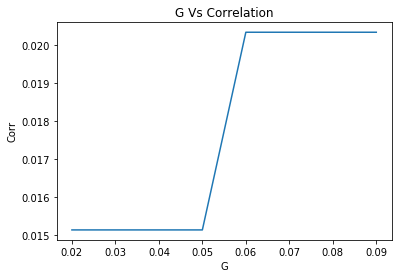

In [20]:
%matplotlib inline
# Plot 
g = []
PCorr = []
for result in results:
    g.append(result[0])
    PCorr.append(result[1])
plt.xlabel('G')
plt.ylabel('Corr')
plt.title('G Vs Correlation')
plt.plot(g, PCorr)
plt.show();


In [21]:
# Show optimized G value for the individual subject
optimized_g = g[PCorr.index(max(PCorr))]
print("The optimized G for subject " + input_name + " is " + str(optimized_g))

The optimized G for subject SC is 0.06


In [22]:
# Save G Vs. Correlation results to .csv file
csv_name = input_name + ".csv"
with open(csv_name, 'w') as f:
    writer = csv.writer(f , lineterminator='\n')
    for tup in results:
        writer.writerow(tup)